In [14]:
from IPython.display import display
from ipywidgets import FloatProgress
import pickle, gzip
import numpy as np
import copy

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-12 14:36:09--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.5’

mnist.pkl.gz.5      100%[===================>]  15.42M  4.84MB/s    in 3.2s    

2019-11-12 14:36:13 (4.84 MB/s) - ‘mnist.pkl.gz.5’ saved [16168813/16168813]



In [3]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, 100, optim='Adam', learning_rate=0.05, verbose=True)

Epoch 10 error 0.58523
Epoch 20 error 0.35420
Epoch 30 error 0.23062
Epoch 40 error 0.16830
Epoch 50 error 0.13260
Epoch 60 error 0.11030
Epoch 70 error 0.09494
Epoch 80 error 0.08357
Epoch 90 error 0.07473
Epoch 100 error 0.07512


In [5]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (output_0): Tanh()
  (flatten): Flatten()
  (output_1): Linear(in_features=640, out_features=10, bias=True)
)
   Network was trained for 100 epochs that took 7.9715 seconds.
   Final objective value is 0.075

In [6]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

Train Percentage: 98.03399999999999, Test Percentage: 96.98


In [7]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 98.5  0    0.2  0    0.2  0.3  0.5  0.2  0.1  0  
 1 |  0   99.1  0.2  0.1  0.1  0.3  0.1  0    0.2  0  
 2 |  0.5  0.5 96.5  0.3  0.3  0.2  0.3  0.8  0.6  0.1
 3 |  0    0    0.7 96.7  0    1.0  0    0.7  0.9  0  
 4 |  0.1  0    0.2  0.1 97.5  0    1.0  0    0    1.1
 5 |  0.1  0    0.3  0.8  0.2 97.1  0.7  0.1  0.6  0.1
 6 |  0.5  0.1  0.2  0.1  0.5  0.8 97.2  0    0.5  0  
 7 |  0.1  0.2  1.2  0.7  0.2  0.2  0   96.8  0.1  0.6
 8 |  0.1  0.1  0.4  0.7  0.6  0.5  0.4  0.6 95.9  0.6
 9 |  0.5  0.4  0    0.7  2.1  0.6  0    1.0  0.4 94.4


In [47]:
def change_pixel(Xset, pixels_to_change=1):
    Xcopy    = copy.copy(Xset)
    bounds   = Xcopy.shape[-1]
    channels = Xcopy.shape[1]
    
    for i in range(len(Xcopy)):
        for rounds in range(pixels_to_change):
            X = np.random.randint(bounds)
            Y = np.random.randint(bounds)
            C = np.random.randint(channels)
            Xcopy[i:i+1, C:C+1, Y:Y+1, X:X+1] = np.random.random(1)
            
    return Xcopy

def imshow(Xset, Xcopy, Tset, same_index, name='grid.pdf'):
    plt.figure(figsize=(9, 4))
    
    n_display = same_index[:14] if len(same_index) > 14 else same_index

    Xcopy_classes, _ = nnet.use(Xcopy[n_display])
    Xset_classes, _  = nnet.use(Xset[n_display])
    
    for i, val in enumerate(n_display):
        plt.subplot(2, 7, i + 1)
        plt.imshow(Xcopy[val, :].reshape(28, 28), cmap='binary')
        plt.title('$X_i$: {0}, $M_i$: {1},\n$T_i$: {2}'.format(Xset_classes[i][0], 
                                                              Xcopy_classes[i][0], 
                                                              Tset[val][0]))
        plt.axis('off');
        
    plt.tight_layout();
    plt.savefig(name, bbox_inches='tight')
    plt.show();

def classified_diff(Xset, Xcopy, Tset):
    Xset_classes, _  = nnet.use(Xset)
    Xcopy_classes, _ = nnet.use(Xcopy)
    
    diff_index = [ i for i in range(len(Xset_classes)) 
                  if Xset_classes[i] == Tset[i] 
                  and Xset_classes[i] != Xcopy_classes[i] ]
    
    return diff_index, 100 - ml.percent_correct(Xset_classes, Xcopy_classes)

def change_in_pixels_plot(Xset, Tset, end_pixel_val=10, trials_per_pixel=5, 
                          errorbar=True, name='img.pdf'):
    plt.figure(figsize=(6, 4))
    change = []
    
    f = FloatProgress(min=0, max=(end_pixel_val * trials_per_pixel))
    display(f)

    for pixels in range(end_pixel_val):
        percent_diff_arr = []
        for trial in range(trials_per_pixel):
            Xcopy = change_pixel(Xtest, pixels_to_change=pixels+1)
            percent_diff_arr.append(classified_diff(Xtest, Xcopy, Ttest)[1])
            
            f.value += 1
        
        change.append(percent_diff_arr)
    
    change = np.array(change)
    
    x = np.arange(1, change.shape[0] + 1)
    y = np.mean(change, axis=1)
    yerr = np.std(change, axis=1)
    
    if errorbar:
        plt.errorbar(x, y, yerr=yerr, marker='.', 
                     lw=1, capsize=5, capthick=1.5, markeredgecolor='k')
    else:
        plt.plot(x, y, marker='.', lw=1, markeredgecolor='k')
        
    plt.xlabel('Number of Pixels Changed')
    plt.ylabel('Mean \% Misclassified')
    plt.grid(True); plt.tight_layout(); 
    plt.savefig(name, bbox_inches='tight')
    plt.show();

Total of 79 misclassified samples,
      with a 1.220% difference from test by changing 1 pixel(s)


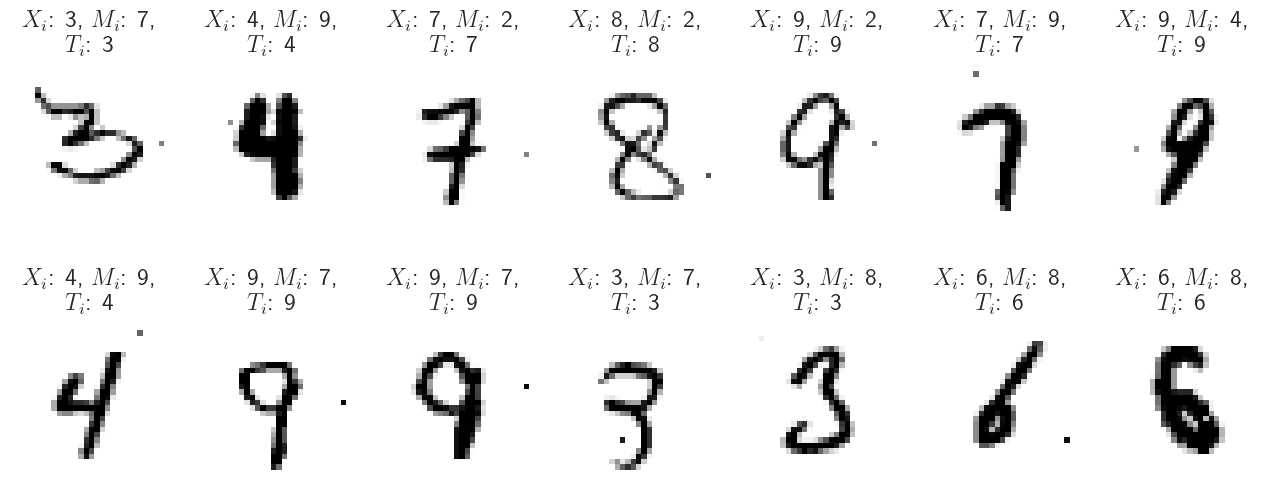

FloatProgress(value=0.0, max=125.0)

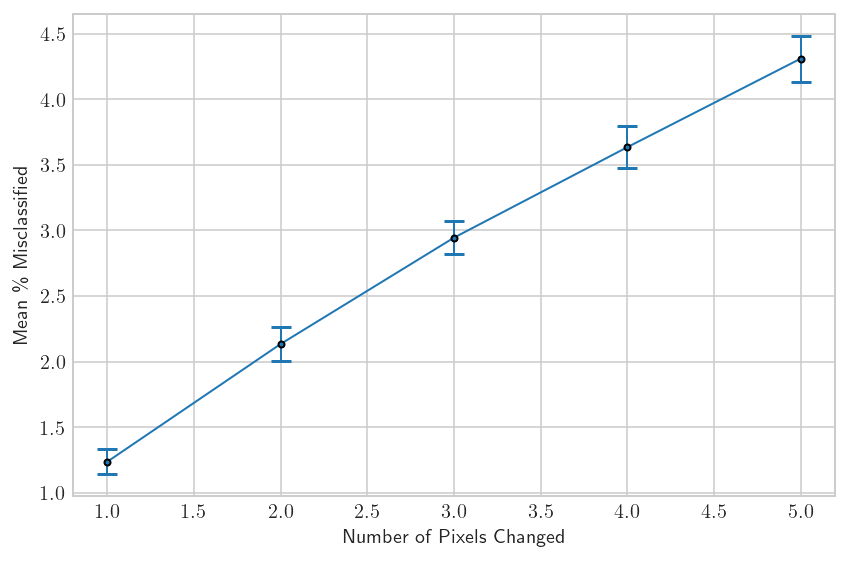

In [48]:
pixels_to_change = 1
Xcopy = change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = classified_diff(Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

imshow(Xtest, Xcopy, Ttest, diff_index, name='mnist_example_1px.pdf')

change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=25, name='mnist_change_5px.pdf')

FloatProgress(value=0.0, max=250.0)

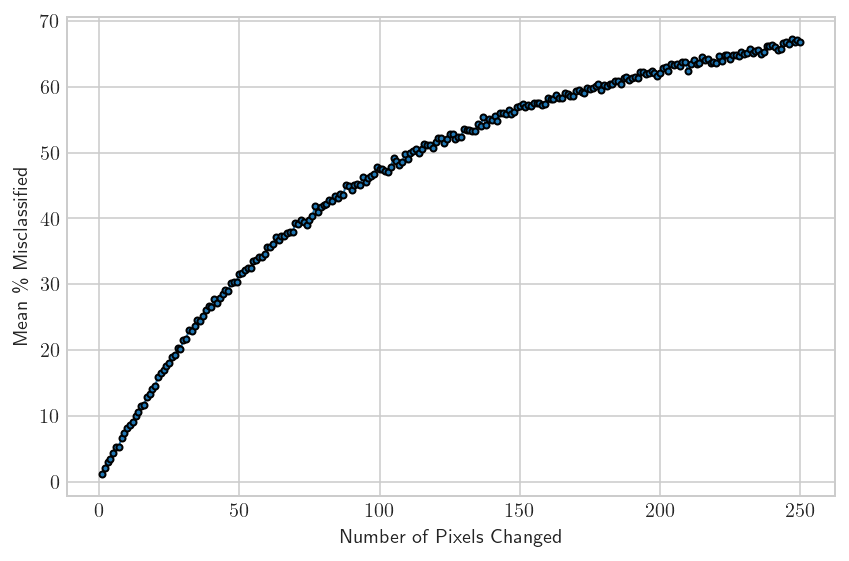

In [49]:
change_in_pixels_plot(Xtest, Ttest, end_pixel_val=250, trials_per_pixel=1,
                      errorbar=False, name='mnist_change_overtime.pdf')